Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [5]:
df.head()


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [6]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)
df['SALE_DATE'].describe()

count                   23040
unique                    120
top       2019-01-24 00:00:00
freq                      480
first     2019-01-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

In [7]:
df['SALE_DATE'].dt.month.value_counts()

1    6464
3    6105
2    5598
4    4873
Name: SALE_DATE, dtype: int64

In [8]:
train = df[df.SALE_DATE.dt.month < 4]
test  = df[df.SALE_DATE.dt.month == 4]
train.shape, test.shape

((18167, 21), (4873, 21))

In [9]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,18167.0,4.447262e+03,3.679406e+03,1.0,1343.0,3569.0,6656.0,16350.0
LOT,18167.0,3.436415e+02,6.061895e+02,1.0,21.0,49.0,286.0,9022.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,18167.0,1.078270e+04,1.121115e+03,0.0,10306.0,11210.0,11360.0,11697.0
RESIDENTIAL_UNITS,18167.0,1.721418e+00,9.381721e+00,0.0,0.0,1.0,2.0,750.0
COMMERCIAL_UNITS,18167.0,2.989486e-01,6.087744e+00,-1.0,0.0,0.0,0.0,570.0
TOTAL_UNITS,18167.0,2.172235e+00,1.166344e+01,0.0,1.0,1.0,2.0,755.0
GROSS_SQUARE_FEET,18167.0,3.214913e+03,2.155829e+04,0.0,528.0,1368.0,2273.5,1303935.0
YEAR_BUILT,18162.0,1.822193e+03,4.836412e+02,0.0,1920.0,1940.0,1965.0,2019.0
TAX_CLASS_AT_TIME_OF_SALE,18167.0,1.617053e+00,8.073494e-01,1.0,1.0,1.0,2.0,4.0


In [10]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')


,count,unique,top,freq,first,last
BOROUGH,18167,5,4,5883,NaT,NaT
TAX_CLASS_AT_PRESENT,18167,10,1,8911,NaT,NaT
NEIGHBORHOOD,18167,11,OTHER,15034,NaT,NaT
BUILDING_CLASS_CATEGORY,18167,43,01 ONE FAMILY DWELLINGS,4094,NaT,NaT
SALE_DATE,18167,90,2019-01-24 00:00:00,480,2019-01-01,2019-03-31
BUILDING_CLASS_AT_PRESENT,18167,140,D4,2640,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,18167,140,D4,2640,NaT,NaT
APARTMENT_NUMBER,3972,1450,4,81,NaT,NaT
LAND_SQUARE_FEET,18139,3207,0,5784,NaT,NaT
ADDRESS,18167,17926,N/A ROCKAWAY BOULEVARD,5,NaT,NaT


In [11]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
NEIGHBORHOOD,,,,,,,,
ASTORIA,266.0,2.134987e+06,1.029145e+07,0.0,0.0,370602.5,919375.0,75000000.0
BEDFORD STUYVESANT,335.0,9.473171e+05,2.594166e+06,0.0,0.0,646589.0,1117500.0,32500000.0
BOROUGH PARK,285.0,4.562094e+05,8.552372e+05,0.0,0.0,0.0,865000.0,9650000.0
EAST NEW YORK,242.0,5.834175e+05,2.291500e+06,0.0,0.0,350000.0,643701.5,24150000.0
FLUSHING-NORTH,549.0,6.626492e+05,2.042354e+06,0.0,0.0,295469.0,836000.0,40433512.0
FOREST HILLS,237.0,5.214604e+05,6.479132e+05,0.0,190000.0,365000.0,675000.0,6205000.0
GRAMERCY,282.0,8.226612e+05,1.694401e+06,0.0,0.0,0.0,1043750.0,18000000.0
OTHER,15034.0,1.209592e+06,1.181147e+07,0.0,0.0,420000.0,810000.0,850000000.0
UPPER EAST SIDE (59-79),343.0,3.335407e+06,7.880025e+06,0.0,467500.0,950000.0,2500000.0,68000000.0


In [12]:
train.groupby('NEIGHBORHOOD')['SALE_PRICE'].mean()


NEIGHBORHOOD
ASTORIA                    2.134987e+06
BEDFORD STUYVESANT         9.473171e+05
BOROUGH PARK               4.562094e+05
EAST NEW YORK              5.834175e+05
FLUSHING-NORTH             6.626492e+05
FOREST HILLS               5.214604e+05
GRAMERCY                   8.226612e+05
OTHER                      1.209592e+06
UPPER EAST SIDE (59-79)    3.335407e+06
UPPER EAST SIDE (79-96)    1.737515e+06
UPPER WEST SIDE (59-79)    1.302832e+06
Name: SALE_PRICE, dtype: float64

In [16]:
target = 'SALE_PRICE'
high_cardinality = ['ADDRESS', 'LAND_SQUARE_FEET', 'APARTMENT_NUMBER', 'BLOCK', 'LOT', 'EASE-MENT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS', 'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]



X_train.head()


,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,BUILDING_CLASS_AT_TIME_OF_SALE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,R4,R4
1,1,OTHER,21 OFFICE BUILDINGS,4,O5,O5
2,1,OTHER,21 OFFICE BUILDINGS,4,O5,O5
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,R4,R4
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,R1,R1


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [18]:
X_train.head()

,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_UPPER WEST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_GRAMERCY,BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_21 OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING_CLASS_CATEGORY_29 COMMERCIAL GARAGES,BUILDING_CLASS_CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING_CLASS_CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING_CLASS_CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING_CLASS_CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING_CLASS_CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING_CLASS_CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING_CLASS_CATEGORY_22 STORE BUILDINGS,BUILDING_CLASS_CATEGORY_10 COOPS - ELEVATOR APARTMENTS,BUILDING_CLASS_CATEGORY_44 CONDO PARKING,BUILDING_CLASS_CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING_CLASS_CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING_CLASS_CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING_CLASS_CATEGORY_27 FACTORIES,BUILDING_CLASS_CATEGORY_04 TAX CLASS 1 CONDOS,...,BUILDING_CLASS_AT_TIME_OF_SALE_RR,BUILDING_CLASS_AT_TIME_OF_SALE_Q9,BUILDING_CLASS_AT_TIME_OF_SALE_M3,BUILDING_CLASS_AT_TIME_OF_SALE_S0,BUILDING_CLASS_AT_TIME_OF_SALE_Z2,BUILDING_CLASS_AT_TIME_OF_SALE_L9,BUILDING_CLASS_AT_TIME_OF_SALE_E7,BUILDING_CLASS_AT_TIME_OF_SALE_D8,BUILDING_CLASS_AT_TIME_OF_SALE_J9,BUILDING_CLASS_AT_TIME_OF_SALE_E2,BUILDING_CLASS_AT_TIME_OF_SALE_W8,BUILDING_CLASS_AT_TIME_OF_SALE_R5,BUILDING_CLASS_AT_TIME_OF_SALE_HB,BUILDING_CLASS_AT_TIME_OF_SALE_H9,BUILDING_CLASS_AT_TIME_OF_SALE_HR,BUILDING_CLASS_AT_TIME_OF_SALE_K3,BUILDING_CLASS_AT_TIME_OF_SALE_I4,BUILDING_CLASS_AT_TIME_OF_SALE_G8,BUILDING_CLASS_AT_TIME_OF_SALE_H7,BUILDING_CLASS_AT_TIME_OF_SALE_G9,BUILDING_CLASS_AT_TIME_OF_SALE_I5,BUILDING_CLASS_AT_TIME_OF_SALE_V9,BUILDING_CLASS_AT_TIME_OF_SALE_RT,BUILDING_CLASS_AT_TIME_OF_SALE_P8,BUILDING_CLASS_AT_TIME_OF_SALE_Z4,BUILDING_CLASS_AT_TIME_OF_SALE_L8,BUILDING_CLASS_AT_TIME_OF_SALE_P2,BUILDING_CLASS_AT_TIME_OF_SALE_L1,BUILDING_CLASS_AT_TIME_OF_SALE_V3,BUILDING_CLASS_AT_TIME_OF_SALE_T2,BUILDING_CLASS_AT_TIME_OF_SALE_RA,BUILDING_CLASS_AT_TIME_OF_SALE_G4,BUILDING_CLASS_AT_TIME_OF_SALE_V2,BUILDING_CLASS_AT_TIME_OF_SALE_H2,BUILDING_CLASS_AT_TIME_OF_SALE_P9,BUILDING_CLASS_AT_TIME_OF_SALE_W4,BUILDING_CLASS_AT_TIME_OF_SALE_W3,BUILDING_CLASS_AT_TIME_OF_SALE_I7,BUILDING_CLASS_AT_TIME_OF_SALE_H4,BUILDING_CLASS_AT_TIME_OF_SALE_K6
0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k = 10)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)


all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)

print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BUILDING_CLASS_CATEGORY_25 LUXURY HOTELS
TAX_CLASS_AT_PRESENT_4
BUILDING_CLASS_AT_PRESENT_O4
BUILDING_CLASS_AT_PRESENT_H1
BUILDING_CLASS_AT_PRESENT_D8
BUILDING_CLASS_AT_PRESENT_K3
BUILDING_CLASS_AT_TIME_OF_SALE_O4
BUILDING_CLASS_AT_TIME_OF_SALE_H1
BUILDING_CLASS_AT_TIME_OF_SALE_D8
BUILDING_CLASS_AT_TIME_OF_SALE_K3


Features not selected:
BOROUGH_1
BOROUGH_2
BOROUGH_3
BOROUGH_4
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_UPPER EAST SIDE (59-79)
NEIGHBORHOOD_UPPER EAST SIDE (79-96)
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_UPPER WEST SIDE (59-79)
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_GRAMERCY
BUILDING_CLASS_CATEGORY_13 CONDOS - ELEVATOR APARTMENTS
BUILDING_CLASS_CATEGORY_21 OFFICE BUILDINGS
BUILDING_CLASS_CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL
BUILDING_CLASS_CATEGORY_07 RENTALS - WALKUP APARTMENTS
BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS
BUILDING_CLASS_CA

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    print(f'{k} features')

    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)

    model = LinearRegression()
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test Mean Absolute Error: ${mae:,.0f} \n')

1 features
Test Mean Absolute Error: $1,781,542 

2 features
Test Mean Absolute Error: $1,781,576 

3 features
Test Mean Absolute Error: $1,752,095 

4 features
Test Mean Absolute Error: $1,752,154 

5 features
Test Mean Absolute Error: $1,732,841 

6 features
Test Mean Absolute Error: $1,732,888 

7 features
Test Mean Absolute Error: $1,724,107 

8 features
Test Mean Absolute Error: $1,721,429 

9 features
Test Mean Absolute Error: $1,847,399 

10 features
Test Mean Absolute Error: $1,846,154 

11 features
Test Mean Absolute Error: $1,845,902 

12 features
Test Mean Absolute Error: $1,845,902 

13 features
Test Mean Absolute Error: $1,831,287 

14 features
Test Mean Absolute Error: $1,830,984 

15 features
Test Mean Absolute Error: $1,834,080 

16 features
Test Mean Absolute Error: $1,827,132 

17 features
Test Mean Absolute Error: $1,826,879 

18 features
Test Mean Absolute Error: $1,819,155 

19 features
Test Mean Absolute Error: $1,819,187 

20 features
Test Mean Absolute Error: $1

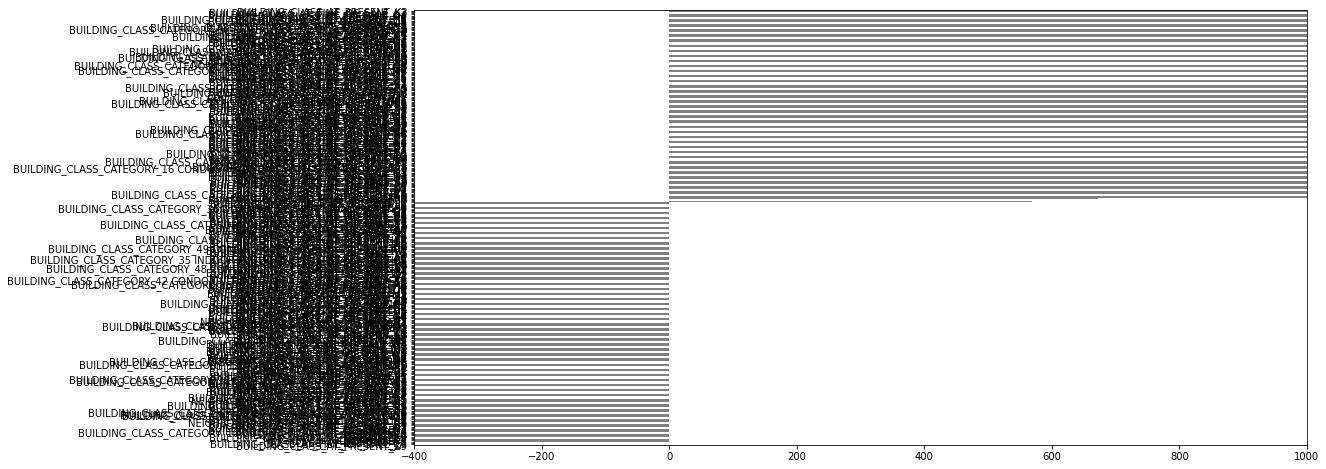

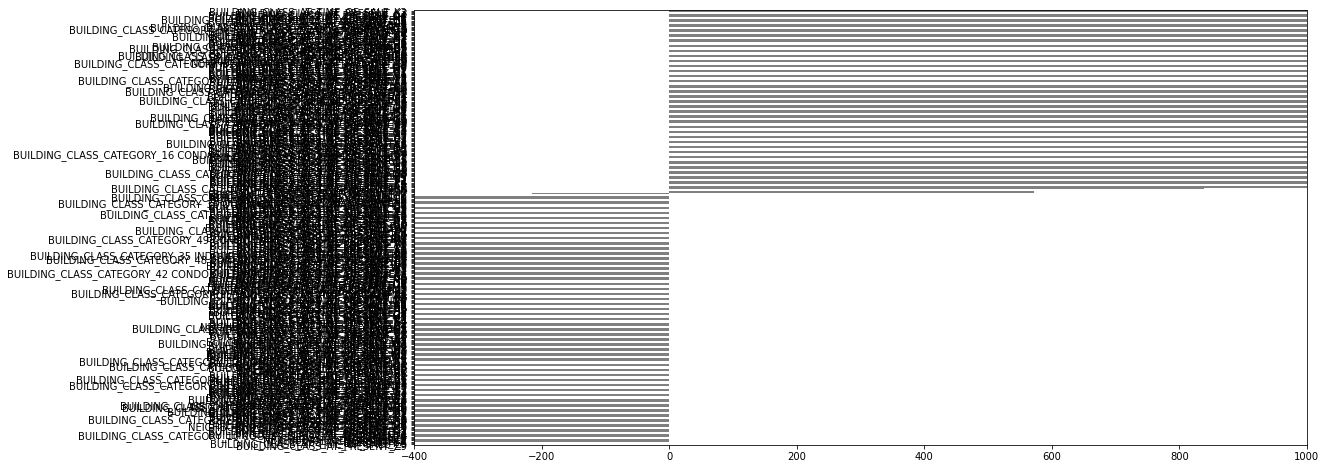

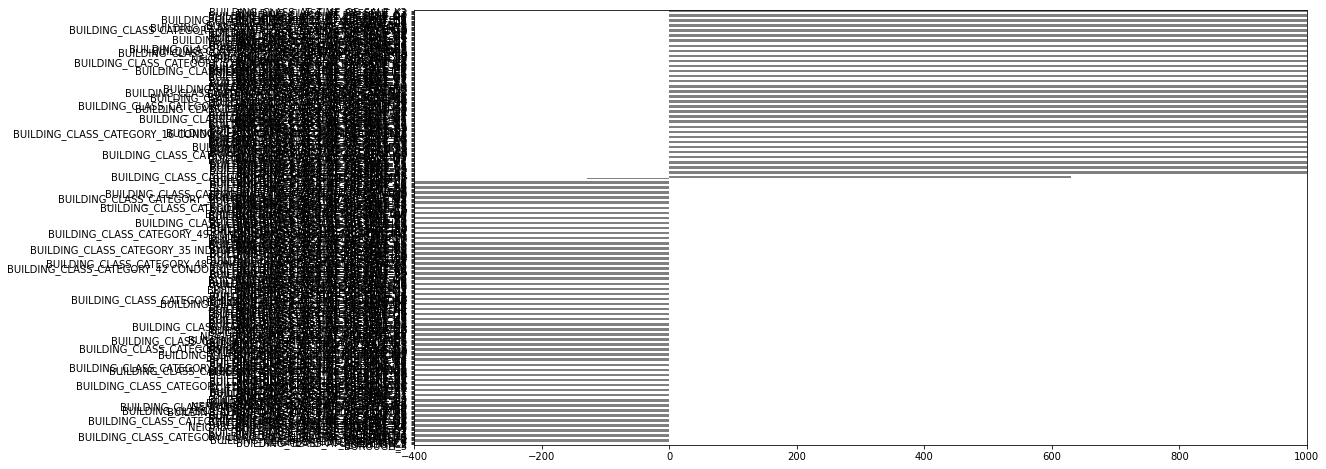

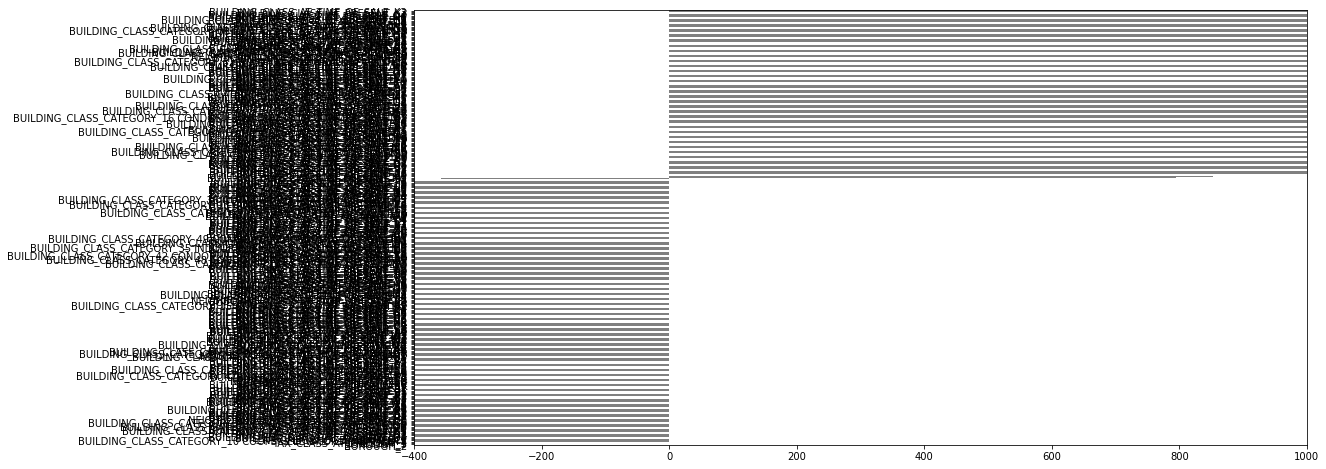

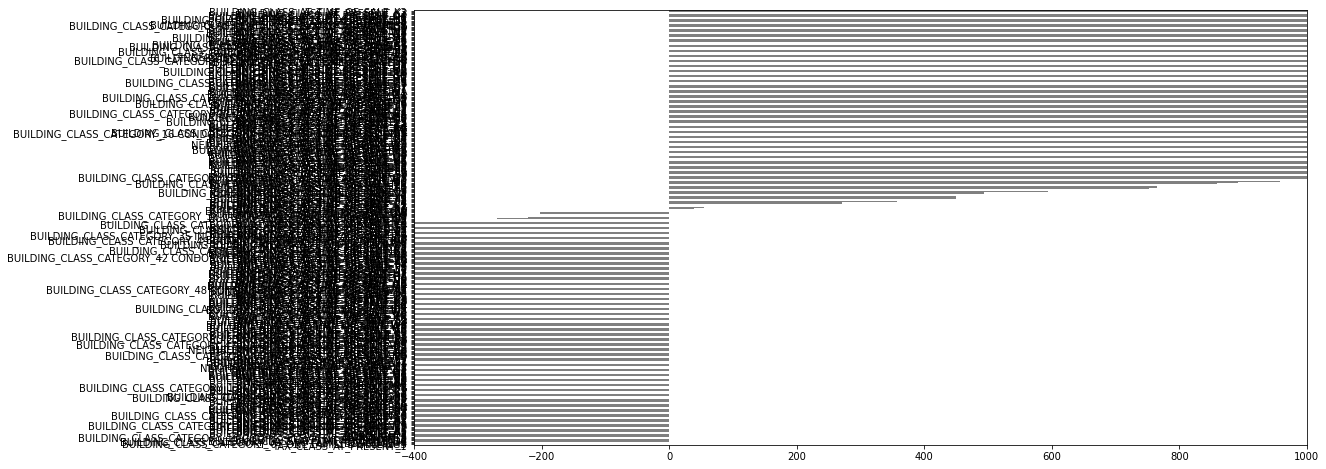

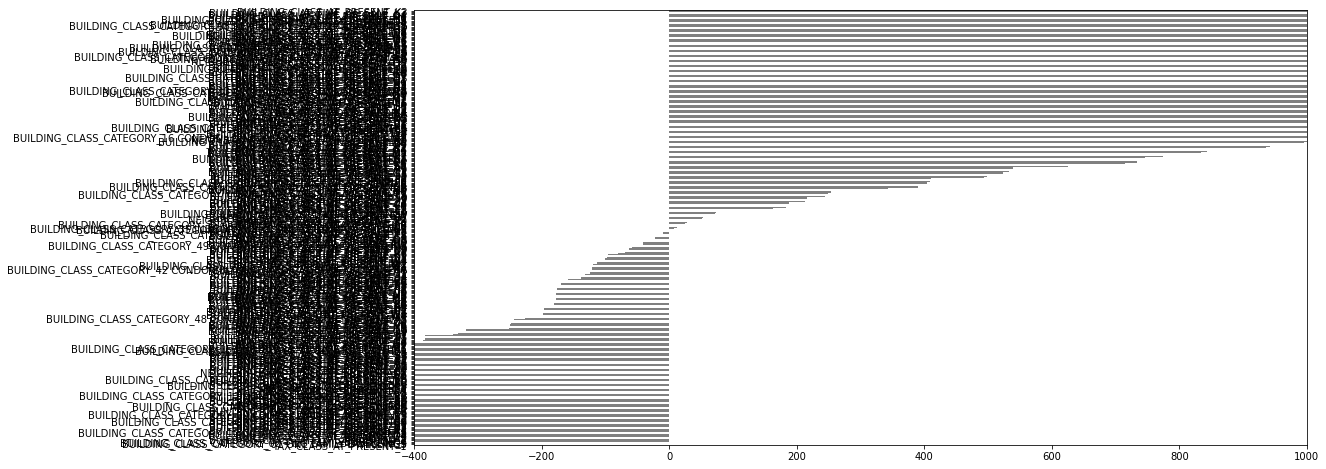

In [21]:
%matplotlib inline
from IPython.display import display, HTML
from ipywidgets import interact
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

for alpha in [10**1, 10**2, 10**3, 10**4, 10**5, 10**6]:
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    

    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha)
    model.fit(X_train_scaled, y_train)


    y_pred = model.predict(X_train_scaled)
    mae = mean_absolute_error(y_train, y_pred)
    display(HTML(f'Train Mean Absolute Error: ${mae:,.0f}'))

    y_pred = model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    coefficients = pd.Series(model.coef_, X_train.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-400,1000)
    plt.show()